In [28]:
import spacy
from spacy import displacy
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

In [29]:
### IMPORTANTE ###
random_state = 100

#este es el random seed para todos los modelos, para obtener siempre los mismos resultados 

### 1. Lea el contenido del fichero csv en un DataFrame.

In [30]:
texto_spam = pd.read_csv("/Users/juan/Documents/Juan's MacBook Pro/CUNEF/Quinto/Informacion no Estructurada/Practica 2/spam.csv") 


### 2. Realice el pre-procesamiento que considere necesario. Puede utilizar funciones de la librería NLTK o spaCy, a su voluntad. Recomendamos una escritura modular del código, para poder hacer pruebas posteriormente, y contestar a las preguntas del punto 6.

In [31]:
texto_spam['label_bin'] = np.where(texto_spam["label"] == 'ham', 0, 1)

Creo la variable label_bin para transormar en 1 si el label es "spam" y 0 si es "ham". Aunque hay muchos modelos que pueden tomar las clases directamente, el xgboost (que es el modelo tipo arbol que he elegido) funciona mejor con 0 y 1.

In [32]:
#Separamos de los datos los documentos y las categorias
docs = texto_spam["text"] # columna de documentos (texto del correo)
categsbin = texto_spam["label_bin"] # columna de categoría en fomra binaria (spam:1 y ham:0)

El unico preprocesamiento que he hecho ha sido separar entre la columna de los documentos y los labels para luego poder generar la matriz tfidf de forma mas sencilla. <br>
Gracias a que el TfidfVectorizer que utilizo a continuacion es capaz de calcular la mariz tfidf con texto en bruto, no necesitamos ni tokenizar, ni realizar previamente la matriz BOW. <br>
La matriz tfidf será el cnjunto de caracteristicas o atributos que usaran nuestros modelos para predecir la etiqueta de spam o ham.


### 3. Divida el conjunto de documentos en un subconjunto de entrenamiento y otro de evaluación.
### 4. Convierta el corpus de documentos en una matriz TF-idf.

Debido a que es mas sencillo realizar la matriz tfidf y luego separar etre train y test, he invertido el orden de los pasos 3 y 4. <br>
Esto se debe a que si separamos antes de hacer el tfidf podriamos cometer el error de luego calcular las frecuencias en base a cada sbconjunto y no a todo el corpus, lo que podria crear sesgos o errores de metodologia. Es decir, queremos que la frecuencia de cada token sea en base a todo el corpus y no de en base a la muestra train o test.

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [34]:
def data_prep(docs, categs, test_size = 0.25):
    """Esta funcion calcula la matriz TF-idf y despues divide el corpus en train y test.
    Ademas, la division entre train y test se estratifica en base a la frequencia de las categorias.
    
    Input: 
        docs: lista de documentos
        categs: lista de categorias
        test_size: tamaño de muestra de test
        
    Output:
        docs_train/_test: matriz Tf-idf de entrenmiento y test
        categs_train/_test: lista de categorias asociadas a cada documento de train/test
    """
    
    vectorizer = TfidfVectorizer()
    spam_tfidf = vectorizer.fit_transform(docs)
    docs_train, docs_test, categs_train, categs_test = train_test_split(spam_tfidf, categsbin, test_size = test_size, 
                                                                        random_state = random_state, stratify=categs)
    return docs_train, docs_test, categs_train, categs_test

In [35]:
docs_train, docs_test, categs_train, categs_test = data_prep(docs, categsbin)

In [36]:
categs_train.value_counts(normalize=True)


0    0.865997
1    0.134003
Name: label_bin, dtype: float64

In [37]:
categs_test.value_counts(normalize=True)

0    0.865757
1    0.134243
Name: label_bin, dtype: float64

Vemos que tanto para train como para test el porcentaje de spam (1) y ham (0) es constante entre ambas muestras. Esto se conoce como estratificar. 

### 5. Llegados a este punto, realice modelos de entrenamiento almenos con algoritmos de clasificador bayesiano ingenuo, máquinas SVM y un modelo basado en árbol de decisión. Obtenga resultados de accuracy de la clasificación, así como las matrices de confusión para los tres modelos.



In [38]:
#Importmos todos los modelos
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

#Importamos matriz de confusion 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [39]:
def run_models(modellist):
    """ Este funcion entrena cada modelo definido en lista input, predice las clases para el conjunto test y
        calcula el accuracy de entrenamiento y test, asi como la matriz de confusion par cada modelo.
        
        Input: 
            modellist: lista de strings con los modelos a entrenar
            
        Output:
            matriz de confusion, accuacy de entrenaiento, test y fiabilidad para cada modelo entrenado
        """
    plt.rcParams["figure.figsize"] = (20,3)
        
    for name in modellist:
        if name == "Bayesiano Ingenuo":
            model = MultinomialNB()
        if name == "SVC":
            model = SVC(kernel='linear')
        if name == "XGBoost":
            model = XGBClassifier(n_jobs = -1, random_state = random_state)


        model.fit(docs_train, categs_train)
        categs_pred = model.predict(docs_test)
        acc_train = model.score(docs_train, categs_train)
        acc_test = model.score(docs_test, categs_test)
        ConfusionMatrixDisplay.from_predictions(categs_test, categs_pred, display_labels = ["ham","spam"]);
        

        # Confusion Matrix
        print('Para el modelo','\033[1m' + str(name) + '\033[0m',"matriz de confusion es:")
        plt.show()
        print("Con un accuracy de train de:", round(acc_train*100,2),"%")
        print("Con un accuracy de test de:", round(acc_test*100,2),"%")
        print("Con una fiabilidad de:", round(acc_test/acc_train*100,2),"%", "\n")

Para el modelo Bayesiano Ingenuo matriz de confusion es:


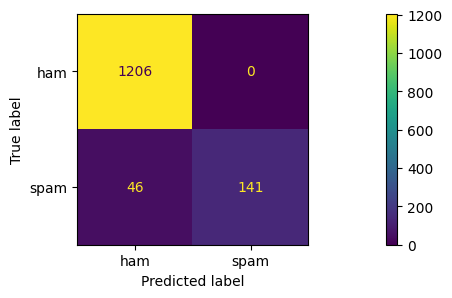

Con un accuracy de train de: 96.48 %
Con un accuracy de test de: 96.7 %
Con una fiabilidad de: 100.22 % 

Para el modelo SVC matriz de confusion es:


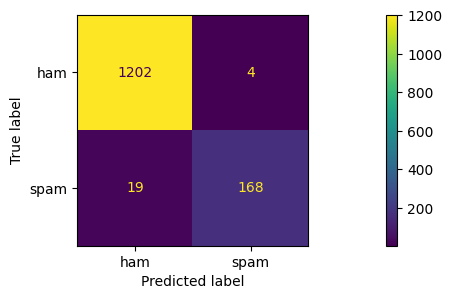

Con un accuracy de train de: 99.69 %
Con un accuracy de test de: 98.35 %
Con una fiabilidad de: 98.66 % 

Para el modelo XGBoost matriz de confusion es:


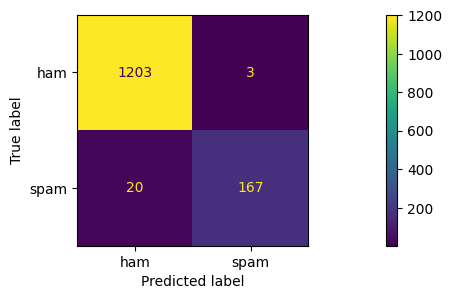

Con un accuracy de train de: 99.76 %
Con un accuracy de test de: 98.35 %
Con una fiabilidad de: 98.58 % 



In [40]:
modellist = ["Bayesiano Ingenuo", "SVC", "XGBoost"]
run_models(modellist)

### 6. (Pregunta convalidable por la actividad de topic modelling. Confirmar con la profesora si está convalidado). Conteste a las siguientes preguntas basándote en evidencias de código. ¿Tiene influencia en el resultado final el número máximo de features a utilizar? ¿Modifica el resultado si se eliminan las stop words? ¿Y si se utilizan las formas canónicas?



Esta pregunta la he convalidado en clase por el topic modelling. De todos modos, el accuacy de los modelos es bastante alto hasta en el bayesiano ingnuo. 
A priori pensaria que eliminar stopwords no tiene sentido ya que por un lado si no tienen capacidad predictiva, el modelo ya los ignorará. De todos modos podria ser que los mensajes de spam tenga una estructura de stopwords diferente a la del los mensajes entre amigos.
Por otro lado las formas canonicas creo que podrian hacer perder algo de capacidad predictiva ya que una gran diferencia en muchos casos es que la palabra este "conjugada" o en una forma slang o mas informal mientras que en caso de spam sea mas formal.

### 7. Imagínese que este entregable es una labor que le han solicitado en un entorno profesional, y que tiene que entregar esta documentación para comentar lo que ha descubierto (datos de entrada, rendimiento de los modelos, o cualquier descubrimiento que pueda ser importante). Comente los resultados obtenidos.

Tras observar las matrices de confusion de todos los modelos, vemos que hasta el bayesiano ingenuo tiene un accuracy muy alto, pero vemos que tiene mas del doble de errores (falsos pasitivos/negativos) que los otros dos modelos.
Los dos modelos probados a parte del bayesiano ingenuo han sido el SVC y el XGBoost.<br>
En ambos casos, el accuracy de test es 99.35%. Ambos son muy precisos y serían muy buenos modelos de prediccion para discernir entre mensajes de spam y normales. <br>
Un valor muy importante a tener en cuenta es que dede un punto de vista de negocio, un falso positivo es mas perjudicial que un falso negativo. Es decir, es peor esconder un mensaje en spam que no lo es (falso positivo), ya que se pueden omitir mensajes importantes, que dejar pasar a la bandeja de entrada un mensaje de spam (falso negativo), que es solo un pequeño inconveniente. <br>
Tanto el SVC como el XGBoost tienen la mayor parte de su error en acumulado en FNs, por lo que en ambos casos estamos contentos en cuanto a conocimieno de negocio. Si tuviera que elegir entre estos dos, aun que sea por una minima diferencia, eligiría el XGBoost ya que tiene menos FPs (por uno) y una ligera mejor prediccion de train.


### Bonus: Fun fact de los datos
<br>
El año pasado estuve en Singapur de intercambio. Aunque sea un pais con ingles como primera lengua, tiene muchas expresiones que derivan de Malasia, China, etc. <br>

Al analizar los documentos me di cuenta de que los mensajes de texto tenían "slang" de Singapur y referencia a calles/ubicaciones de Singapur

In [78]:
pd.options.display.max_colwidth = 100
print(texto_spam["text"][0], "\n")

Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat... 



Jurong point y Bugis son lugares en Singapur.

In [79]:
print(texto_spam["text"][2488])

Aiyah e rain like quite big leh. If drizzling i can at least run home.


In [87]:
vectorizer = TfidfVectorizer()
spam_tfidf = vectorizer.fit_transform(docs)

vocab = vectorizer.get_feature_names_out()
TFIDFdf = pd.DataFrame(spam_tfidf.toarray(), columns=vocab)
TFIDFdf

,00,000,000pes,008704050406,0089,0121,01223585236,01223585334,0125698789,02,...,û_,û_thanks,ûªm,ûªt,ûªve,ûï,ûïharry,ûò,ûówell,žö
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5569,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5570,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [94]:
TFIDFdf["leh"].sort_values(ascending=False)

213     0.496523
3426    0.478422
223     0.425065
3902    0.375762
3446    0.372585
          ...   
1860    0.000000
1859    0.000000
1858    0.000000
1857    0.000000
5571    0.000000
Name: leh, Length: 5572, dtype: float64

In [96]:
print(texto_spam["text"][3426])

Haha okay... Today weekend leh... 


In [97]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 1.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 1.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.1/182.1 kB 2.0 MB/s eta 0:00:00a 0:00:01


In [104]:
import transformers

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
